In [1]:
import os
import glob
from datasets import load_dataset
import pprint

import matplotlib.pyplot as plt
from utils import *


/Users/lucathale-bombien/PycharmProjects/Probabilistic-Machine-Learning_lecture-PROJECTS3/snetuna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# assumes data has been downloaded locally
local_dir = "../data"
parquet_pattern = os.path.join(local_dir, "train-*-of-*.parquet")
shard_paths = sorted(glob.glob(parquet_pattern))

if not shard_paths:
    raise RuntimeError(f"No parquet files found at pattern {parquet_pattern}")

# loads local data
ds_stream = load_dataset(
    "parquet",
    data_files={"games": shard_paths},
    split="games",
    streaming=True
)

# limit to max_matches as resources are limited
max_matches = 5000000
filtered_rows = []

# Iterate over games and append matching games to array
for game in ds_stream:
    if keep_game(game):
        filtered_rows.append(game)
        if len(filtered_rows) >= max_matches:
            break

# Convert filtered games to pandas.DataFrame
df_filtered = pd.DataFrame(filtered_rows)
print(f"Collected {len(df_filtered)} games (up to {max_matches}).")
print(df_filtered.head(50))


Collected 683254 games (up to 5000000).
                                                Event  \
0      Rapid swiss https://lichess.org/swiss/2V3L9Zwn   
1      Rapid swiss https://lichess.org/swiss/T9vocdaQ   
2      Rapid swiss https://lichess.org/swiss/T9vocdaQ   
3      Rapid swiss https://lichess.org/swiss/7siKNYGN   
4      Rapid swiss https://lichess.org/swiss/7siKNYGN   
5      Rapid swiss https://lichess.org/swiss/7siKNYGN   
6      Rapid swiss https://lichess.org/swiss/7siKNYGN   
7      Rapid swiss https://lichess.org/swiss/iQC7K9kp   
8      Rapid swiss https://lichess.org/swiss/iQC7K9kp   
9      Rapid swiss https://lichess.org/swiss/iQC7K9kp   
10     Rapid swiss https://lichess.org/swiss/iQC7K9kp   
11     Rapid swiss https://lichess.org/swiss/iQC7K9kp   
12     Rapid swiss https://lichess.org/swiss/s48lWjcR   
13     Rapid swiss https://lichess.org/swiss/Z6Cmixc1   
14                                   Rated Rapid game   
15                                   Rated Rapid

In [3]:
save_dataframe(df=df_filtered, path="../data/raw_30_shards")

In [2]:
df_filtered = load_dataframe(path="../data/raw_30_shards")

In [3]:
white_elos = df_filtered['WhiteElo']
black_elos = df_filtered['BlackElo']
b_counts = black_elos.value_counts()
w_counts = white_elos.value_counts()
print(b_counts.idxmax() if not b_counts.empty else None)
print(w_counts.idxmax() if not w_counts.empty else None)

1745
1472


In [3]:
#Compute Elo distribution (mean and median) for White and Black
white_elos = df_filtered['WhiteElo']
black_elos = df_filtered['BlackElo']

elo_stats = pd.DataFrame({
    'Color': ['White', 'Black'],
    'Mean_Elo': [white_elos.mean(), black_elos.mean()],
    'Median_Elo': [white_elos.median(), black_elos.median()],
    'Max_Elo': [white_elos.max(), black_elos.max()],
    'Min_Elo': [white_elos.min(), black_elos.min()],
    'STD_Elo': [white_elos.std(), black_elos.std()],
})
print("=== Elo Statistics ===")
print(elo_stats)


def count_full_moves(move_text: str) -> int:
    # Find all move‐number prefixes like "1. ", "2. ", etc.
    numbers = re.findall(r'\b(\d+)\.\s', move_text)
    if not numbers:
        return 0
    return max(map(int, numbers))

# Apply to every row
df_filtered['parsed_num_moves'] = df_filtered['movetext'].apply(count_full_moves)

# statistics for game length
move_length_stats = df_filtered['parsed_num_moves'].describe()
print("\n=== Game‐Length Statistics (in full‐move counts) ===")
print(move_length_stats)


=== Elo Statistics ===
   Color     Mean_Elo  Median_Elo  Max_Elo  Min_Elo     STD_Elo
0  White  1537.382037      1543.0     3119      400  396.461465
1  Black  1538.204712      1545.0     3116      400  396.433835

=== Game‐Length Statistics (in full‐move counts) ===
count    683254.000000
mean         33.321629
std          14.920046
min           4.000000
25%          23.000000
50%          30.000000
75%          41.000000
max         227.000000
Name: parsed_num_moves, dtype: float64


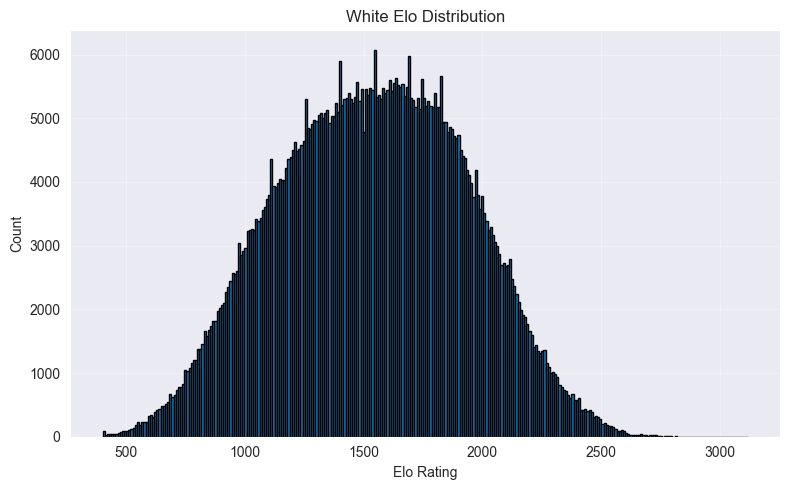

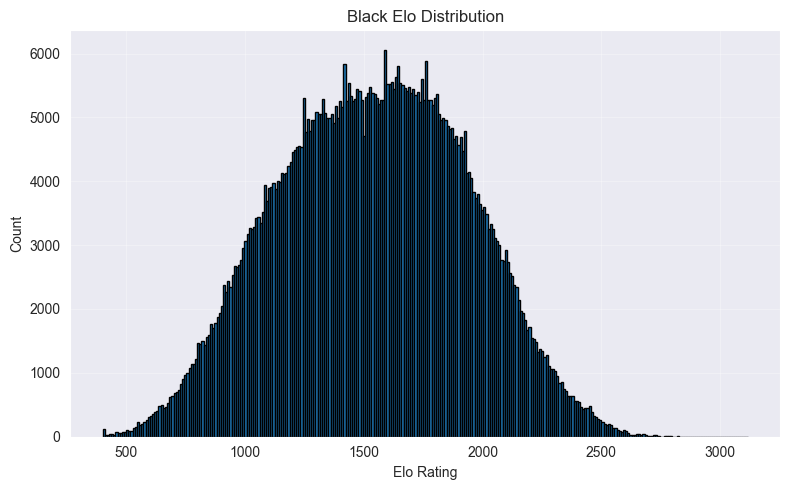

In [4]:
# Extract Elo ratings
white_elos = df_filtered["WhiteElo"]
black_elos = df_filtered["BlackElo"]

#  White Elo Distribution
plt.figure(figsize=(8, 5))
plt.hist(white_elos, bins=300, edgecolor="black")
plt.title("White Elo Distribution")
plt.xlabel("Elo Rating")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Black Elo Distribution
plt.figure(figsize=(8, 5))
plt.hist(black_elos, bins=300, edgecolor="black")
plt.title("Black Elo Distribution")
plt.xlabel("Elo Rating")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
#Parse the movetext and identify individual moves and their corresponding rating change as captured by stockfish
df_filtered['moves_evals'] = df_filtered['movetext'].apply(parse_moves_and_evals_with_delta)
# View the first game’s parsed moves, evals, and deltas
print(df_filtered.loc[0, 'moves_evals'])


    move_number  color    move     eval  delta_eval
0             1  white      e4     0.18        0.00
1             1  black      e5     0.21        0.03
2             2  white     Nf3     0.13       -0.08
3             2  black      d6     0.48        0.35
4             3  white     Bc4     0.25       -0.23
5             3  black     f6?     1.34        1.09
6             4  white      d3     0.97       -0.37
7             4  black      c5     1.35        0.38
8             5  white     Be3     0.97       -0.38
9             5  black    b6??     5.48        4.51
10            6  white   O-O??     1.84       -3.64
11            6  black   Be7??     5.42        3.58
12            7  white    Nc3?     2.68       -2.74
13            7  black   Nh6??     6.27        3.59
14            8  white   Nd5??     3.20       -3.07
15            8  black    Bf8?     5.42        2.22
16            9  white    Nc3?     4.31       -1.11
17            9  black     b5?     5.96        1.65
18          

In [6]:
# compute average centipawn loss per move and extend feature DF
df_filtered[['white_accuracy_cp', 'black_accuracy_cp']] = (
    df_filtered['moves_evals']
      .apply(compute_accuracy_cp_from_moves_evals)
)

# Inspect
print(df_filtered[['white_accuracy_cp','black_accuracy_cp']])


        white_accuracy_cp  black_accuracy_cp
0             3364.133333        6694.300000
1             2868.485714        5724.971429
2              132.500000        5123.850000
3             4967.750000        7472.200000
4               70.218750        3196.656250
...                   ...                ...
683249          14.666667          33.710526
683250          50.000000          33.043478
683251        9164.000000       18250.363636
683252          71.000000          98.291667
683253        4531.454545        3115.769231

[683254 rows x 2 columns]


In [7]:
# apply feature extraction to all games
features_list = df_filtered["moves_evals"].apply(extract_game_features)
features_df = pd.DataFrame(features_list.tolist())




In [10]:
print(len(features_df[features_df.illegal_game == False]))

683248


In [11]:
features_df = features_df[features_df.illegal_game == False]

In [12]:
save_dataframe(df=features_df, path="../data/egf_30_shards")

In [17]:
print(pd.json_normalize(features_list).columns)

Index(['total_full_moves', 'illegal_game', 'moves_before_castle.white',
       'moves_before_castle.black', 'pawn_counts_at.white.25',
       'pawn_counts_at.white.50', 'pawn_counts_at.white.75',
       'pawn_counts_at.white.100', 'pawn_counts_at.black.25',
       'pawn_counts_at.black.50', 'pawn_counts_at.black.75',
       'pawn_counts_at.black.100', 'legal_move_diff_at.25',
       'legal_move_diff_at.50', 'legal_move_diff_at.75',
       'legal_move_diff_at.100', 'development_before.white',
       'development_before.black', 'center_control_after_5.white',
       'center_control_after_5.black', 'unique_pieces_after_10.white',
       'unique_pieces_after_10.black', 'blunder_counts.white',
       'blunder_counts.black', 'first_blunder_move.white',
       'first_blunder_move.black', 'mistake_counts.white',
       'mistake_counts.black', 'first_mistake_move.white',
       'first_mistake_move.black', 'first_win_opportunity.white',
       'first_win_opportunity.black', 'first_opp_win_opport

In [18]:
# flatten one level of nesting (white/black):
raw = pd.json_normalize(features_list)
raw.drop(columns=["illegal_game"], inplace=True)
# This creates columns like “moves_before_castle.white” and “moves_before_castle.black”,
# as well as “pawn_counts_at.25.white” etc.

# Rename columns to look like “moves_before_castle_white”:
raw.columns = [col.replace(".", "_") for col in raw.columns]

# Some columns (like pawn_counts_at_25_white) contain 3‑tuples (iso, dbl, tri).
# We detect those columns whose values are tuples and split each tuple into three new columns.

# Find columns with tuple values:
tuple_cols = [
    c for c in raw.columns
    if raw[c].apply(lambda x: isinstance(x, tuple)).any()
]

for col in tuple_cols:
    # Create three new columns from the tuple (iso, dbl, tri)
    raw[[f"{col}_iso", f"{col}_dbl", f"{col}_tri"]] = pd.DataFrame(
        raw[col].tolist(), index=raw.index
    )
    # Drop the original “tuple” column
    raw.drop(columns=[col], inplace=True)

# “raw” is now fully flattened. Every white/black metric is two separate columns,
# and any triple‑tuple fields (pawn_counts, doubled, tripled) have been unpacked.

print(raw.columns)

Index(['total_full_moves', 'moves_before_castle_white',
       'moves_before_castle_black', 'legal_move_diff_at_25',
       'legal_move_diff_at_50', 'legal_move_diff_at_75',
       'legal_move_diff_at_100', 'development_before_white',
       'development_before_black', 'center_control_after_5_white',
       'center_control_after_5_black', 'unique_pieces_after_10_white',
       'unique_pieces_after_10_black', 'blunder_counts_white',
       'blunder_counts_black', 'first_blunder_move_white',
       'first_blunder_move_black', 'mistake_counts_white',
       'mistake_counts_black', 'first_mistake_move_white',
       'first_mistake_move_black', 'first_win_opportunity_white',
       'first_win_opportunity_black', 'first_opp_win_opportunity_white',
       'first_opp_win_opportunity_black', 'knight_edge_first_white',
       'knight_edge_first_black', 'knight_edge_count_white',
       'knight_edge_count_black', 'rook_7th_first_white',
       'rook_7th_first_black', 'pawn_counts_at_white_25_iso'

In [19]:
df = aggregate_ingame_metrics(df_filtered, group_col= 'ECO', agg_funcs = ['mean', 'median', 'std'])
df2 =aggregate_ingame_metrics(df_filtered, group_col= 'White', agg_funcs = ['mean', 'median', 'std'])

In [23]:
t = pd.concat([df_filtered, df], axis=1)
t = pd.concat([t, df2], axis=1)

In [25]:
print(t.columns)

Index(['Event', 'Site', 'White', 'Black', 'Result', 'WhiteTitle', 'BlackTitle',
       'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'UTCDate',
       'UTCTime', 'ECO', 'Opening', 'Termination', 'TimeControl', 'movetext',
       'parsed_num_moves', 'moves_evals', 'white_accuracy_cp',
       'black_accuracy_cp', 'Event', 'Site', 'White', 'Black', 'Result',
       'WhiteTitle', 'BlackTitle', 'WhiteElo', 'BlackElo', 'WhiteRatingDiff',
       'BlackRatingDiff', 'UTCDate', 'UTCTime', 'ECO', 'Opening',
       'Termination', 'TimeControl', 'movetext', 'parsed_num_moves',
       'moves_evals', 'white_accuracy_cp', 'black_accuracy_cp',
       'ECO_white_accuracy_cp_mean', 'ECO_white_accuracy_cp_median',
       'ECO_white_accuracy_cp_std', 'ECO_black_accuracy_cp_mean',
       'ECO_black_accuracy_cp_median', 'ECO_black_accuracy_cp_std', 'Event',
       'Site', 'White', 'Black', 'Result', 'WhiteTitle', 'BlackTitle',
       'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff

In [44]:
final_df = pd.concat([t, raw], axis=1)

In [45]:
print(final_df.columns)

Index(['Event', 'Site', 'White', 'Black', 'Result', 'WhiteTitle', 'BlackTitle',
       'WhiteElo', 'BlackElo', 'WhiteRatingDiff',
       ...
       'pawn_counts_at_black_25_tri', 'pawn_counts_at_black_50_iso',
       'pawn_counts_at_black_50_dbl', 'pawn_counts_at_black_50_tri',
       'pawn_counts_at_black_75_iso', 'pawn_counts_at_black_75_dbl',
       'pawn_counts_at_black_75_tri', 'pawn_counts_at_black_100_iso',
       'pawn_counts_at_black_100_dbl', 'pawn_counts_at_black_100_tri'],
      dtype='object', length=133)


In [47]:
# drop unnecessary columns
final_df.drop([
    "movetext", "White", "Black", "BlackTitle", "WhiteTitle", "UTCDate", "Event", "BlackRatingDiff", "UTCTime", "TimeControl", "Site", "WhiteRatingDiff", "moves_evals"
], axis=1, inplace=True)

print(final_df.columns)

Index(['Result', 'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination',
       'parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp', 'Result',
       'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination',
       'parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp',
       'ECO_white_accuracy_cp_mean', 'ECO_white_accuracy_cp_median',
       'ECO_white_accuracy_cp_std', 'ECO_black_accuracy_cp_mean',
       'ECO_black_accuracy_cp_median', 'ECO_black_accuracy_cp_std', 'Result',
       'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination',
       'parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp',
       'White_white_accuracy_cp_mean', 'White_white_accuracy_cp_median',
       'White_white_accuracy_cp_std', 'White_black_accuracy_cp_mean',
       'White_black_accuracy_cp_median', 'White_black_accuracy_cp_std',
       'total_full_moves', 'moves_before_castle_white',
       'moves_before_castle_black', 'legal_move_diff_at_25',
       'legal_move_diff_at_50', 'leg

In [48]:
final_df = final_df.loc[:, ~final_df.T.duplicated()]


In [50]:
print(final_df.columns)

Index(['Result', 'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination',
       'parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp',
       'ECO_white_accuracy_cp_mean', 'ECO_white_accuracy_cp_median',
       'ECO_white_accuracy_cp_std', 'ECO_black_accuracy_cp_mean',
       'ECO_black_accuracy_cp_median', 'ECO_black_accuracy_cp_std',
       'White_white_accuracy_cp_mean', 'White_white_accuracy_cp_median',
       'White_white_accuracy_cp_std', 'White_black_accuracy_cp_mean',
       'White_black_accuracy_cp_median', 'White_black_accuracy_cp_std',
       'total_full_moves', 'moves_before_castle_white',
       'moves_before_castle_black', 'legal_move_diff_at_25',
       'legal_move_diff_at_50', 'legal_move_diff_at_75',
       'legal_move_diff_at_100', 'development_before_white',
       'development_before_black', 'center_control_after_5_white',
       'unique_pieces_after_10_white', 'unique_pieces_after_10_black',
       'blunder_counts_white', 'blunder_counts_black',
       'fir

In [51]:
# Save feature Data
save_dataframe(df=final_df, path="../data/final_data_30_shards")
save_and_verify(df=final_df, path="../data/final_data_30_shards")

,Result,WhiteElo,BlackElo,ECO,Opening,Termination,parsed_num_moves,white_accuracy_cp,black_accuracy_cp,ECO_white_accuracy_cp_mean,...,pawn_counts_at_black_25_tri,pawn_counts_at_black_50_iso,pawn_counts_at_black_50_dbl,pawn_counts_at_black_50_tri,pawn_counts_at_black_75_iso,pawn_counts_at_black_75_dbl,pawn_counts_at_black_75_tri,pawn_counts_at_black_100_iso,pawn_counts_at_black_100_dbl,pawn_counts_at_black_100_tri
0,1-0,887,684,C41,Philidor Defense,Normal,31,3364.133333,6694.300000,1875.643229,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0-1,761,431,C42,Petrov's Defense: Damiano Variation,Time forfeit,35,2868.485714,5724.971429,2554.009384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1-0,565,863,C40,King's Knight Opening,Normal,21,132.500000,5123.850000,2678.581615,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
3,1-0,939,404,C41,Philidor Defense,Normal,41,4967.750000,7472.200000,1875.643229,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0
4,1-0,1094,660,C25,Vienna Game: Max Lange Defense,Normal,33,70.218750,3196.656250,2359.505593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683249,1-0,1698,1706,B00,Pirc Defense,Normal,39,14.666667,33.710526,2239.542025,...,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
683250,0-1,1845,1946,A08,Zukertort Opening: Reversed Grünfeld,Normal,24,50.000000,33.043478,1235.407973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
683251,1-0,1379,1410,B21,Sicilian Defense: Smith-Morra Gambit,Normal,12,9164.000000,18250.363636,1752.979776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
683252,1-0,1450,1453,D01,"Rapport-Jobava System, with e6",Normal,25,71.000000,98.291667,1968.994678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
